In [2]:
import pandas as pd
import numpy as np

from pydumbo import merchant_signals as MerchantSignals
from kplib.dumbo import Dumbo, DataframeInput, FeatureOptions,EvaluationOptions, FileInput

from sklearn.metrics import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

from pysnowflake.simple import Session
from pysnowflake.utils import retrieve_query
from pysnowflake.utils import write_df_to_snowflake

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import json
#import RiskarbiterService
#from pyriskarbiter.services.riskarbiter import RiskarbiterService
#from tqdm import tqdm


from sklearn.model_selection import train_test_split #
from sklearn.tree import DecisionTreeClassifier
pd.options.display.max_columns = 25
pd.options.display.max_rows = 25
pd.set_option('display.float_format', '{:.2f}'.format)

from sklearn import metrics
import blocks
from blocks.filesystem import GCSFileSystem

pd.options.display.max_rows = 4000

/usr/local/lib/python3.7/site-packages/snowflake/connector/options.py:78: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
  warn_incompatible_dep('pyarrow', _installed_pyarrow_version.version, _expected_pyarrow_version)


In [1]:
create_query ="""CREATE OR REPLACE TABLE APP_RISK.APP_RISK_TEST.NMAVANI_ACUITY_RULE_SAMPLE AS
SELECT DISTINCT fpt.UNIT_TOKEN
, fpt.PAYMENT_TOKEN
, PAYMENT_TRX_RECOGNIZED_AT
, fpt.PAYMENT_ENTRY_METHOD
, fpt.AMOUNT_BASE_UNIT_USD
, fpt.AMOUNT_BASE_UNIT
, fpt.CURRENCY_CODE
, du.is_currently_deactivated
, du.is_currently_frozen
, s.GMGB_SCORE as GMGB_SCORE
, S.BF_SCORE_OVER
, S.BF_SCORE_UNDER
, DATEDIFF(DAY, DU.first_successful_activation_request_approved_at_date,PAYMENT_TRX_RECOGNIZED_AT ) AS TENURE
, NVL(CB.CHARGEBACK_CENTS * Cer.exchange_rate_fxd * cer.base_unit_to_unit_multiplier,0) as chargebacks_usd
, NVL(CB.LOSS_CENTS * Cer.exchange_rate_fxd * cer.base_unit_to_unit_multiplier,0) as loss_usd
, CASE WHEN CB.PAYMENT_TOKEN IS NOT NULL THEN 1 ELSE 0 END AS IS_CHARGRBACKED
, LISTAGG(DISTINCT concern, ',') as concerns_suspected
, MAX(sus.is_suspected) AS IS_SUSPECTED
, MAX(sus.is_cased) AS IS_CASED
, MAX(sus.case_id) AS CASE_ID
FROM app_bi.pentagon.fact_payment_transactions fpt
left join app_risk.app_risk.chargebacks cb on
    cb.payment_token = fpt.payment_token
    and cb.type = 'fraud'
left join app_bi.pentagon.dim_user du
    on du.user_token = fpt.unit_token
    and is_unit = 1
LEFT JOIN  APP_BI.APP_BI_DW.DIM_EXCHANGE_RATE cer
    ON cer.report_date = TO_DATE(cb.chargeback_date)
    AND cer.currency_code_base = cb.currency_code
    AND cer.currency_code_counter = 'USD'
LEFT JOIN
    (select  eventkey, dmeta_datestring
      , CASE WHEN MODELNAME ILIKE 'xgb_gmgb_payments_tag_v5_20190528' THEN score ELSE NULL END AS GMGB_SCORE
        , CASE WHEN MODELNAME ILIKE 'ml__over100_global_bf_api__20191118_v1' THEN score ELSE NULL END AS BF_SCORE_UNDER
        , CASE WHEN MODELNAME ILIKE 'globalbf_decline_api_over100_20191111_capt' THEN score ELSE NULL END AS BF_SCORE_OVER
     from APP_RISK.APP_RISK.RISKARBITER_SCORED_EVENT
     where dmeta_datestring >= DATEADD(DAY, -95, '2021-02-28')
     and DMETA_DATESTRING <= '2021-02-28'
     and MODELNAME in ( 'xgb_gmgb_payments_tag_v5_20190528', 'xgb_bf_api_under100_202007', 'globalbf_decline_api_over100_20191111_capt')) s
   on fpt.payment_token = s.eventkey
LEFT JOIN  SKEPTIC.RAW_OLTP.INTERNAL_SUSPICIONS SUS
    ON SUS.EVENT_TOKEN = FPT.PAYMENT_TOKEN
    AND SUS.EVENT_TYPE = 'feed_payment'
    AND IS_SUSPECTED = TRUE
WHERE PAYMENT_ENTRY_METHOD IN (
'Square Connect API',
'Square Connect API Card On File',
'Appointments Keyed',
'Appointments',
'Square eGift')
AND PAYMENT_TRX_RECOGNIZED_AT BETWEEN '2020-12-01' AND '2021-02-28'
AND IS_GPV = 1
AND IS_VOIDED = 0
AND IS_CARD_PAYMENT = 1
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, CB.PAYMENT_TOKEN"""


input_query = """select * from APP_RISK.APP_RISK_TEST.NMAVANI_ACUITY_RULE_SAMPLE"""

In [2]:
print(input_query)

select * from APP_RISK.APP_RISK_TEST.NMAVANI_ACUITY_RULE_SAMPLE


In [27]:
with Session(app_name="APP_RISK") as ss:
    
    df = ss.download(
        table = "APP_RISK.APP_RISK_TEST.NMAVANI_ACUITY_RULE_SAMPLE",
        path="gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_snowflake/",
    )

In [2]:
signals = [
    #bin related
    'bin_streak_length_by_merchant_from_payment_merchant',
    'bin_decline_rate_by_merchant_from_payment_merchant',
    'unique_bins_by_merchant_from_payment_merchant',
    'bin_diversity_by_merchant_from_payment_merchant',
    #pan related
    'pan_diversity_by_merchant_from_payment_merchant',
    'pan_success_rate_by_merchant_from_payment_merchant',
    'pan_decline_rate_by_merchant_from_payment_merchant',
    #total capture/amount by merchant
    'total_amount_b_in_1d_by_merchant_from_payment_merchant',
    'avg_capture_amount_b_in_1d_by_merchant_from_payment_merchant',
    'avg_capture_amount_in_1w_by_merchant_from_payment_merchant',
    'avg_capture_amount_in_2w_by_merchant_from_payment_merchant',
    'avg_capture_amount_by_merchant_from_payment_merchant',
    'avg_amount_by_merchant_from_payment_merchant',
    'avg_amount_b_in_1d_by_merchant_from_payment_merchant',
    'avg_amount_b_in_4w_by_merchant_from_payment_merchant',
    'avg_amount_in_4w_by_merchant_from_payment_merchant',
    #total capture/amount by card
    'lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin',
    'lagged_chargeback_rate_by_amount_by_payment_card_bin_from_payment_card_bin',
    'lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin',
    'lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin',
    'total_amount_by_card_from_payment_card',
    'avg_capture_amount_b_in_1d_by_card_from_payment_card',
    'total_amount_b_in_1w_by_merchant_from_payment_merchant',
    'total_amount_b_in_2w_by_merchant_from_payment_merchant',
    #total capture by payment card and merchant
    'total_amount_in_2w_by_merchant_and_card_from_payment_merchant_and_card',
    #model scores


]

In [ ]:
Dumbo().get_features(
        entity="REGISTER_PAYMENT",
        input_query=FileInput("gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_snowflake", token_col="PAYMENT_TOKEN"),
        #output_path="gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_dumbo",
        output_path="gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_dumbo_new",
        feature_options=FeatureOptions(
            features=signals, 
            include_deprecated=True
        ),
        evaluation_options=EvaluationOptions(
            acl_reasons=["risk"]),
    )

In [3]:
df_features = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_dumbo_new/results')
df_new = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_snowflake')

In [12]:
df_new.head()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,PAYMENT_ENTRY_METHOD,AMOUNT_BASE_UNIT_USD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,GMGB_SCORE,BF_SCORE_OVER,BF_SCORE_UNDER,TENURE,CHARGEBACKS_USD,LOSS_USD,IS_CHARGRBACKED,CONCERNS_SUSPECTED,IS_SUSPECTED,IS_CASED,CASE_ID
0,LN1PYG916SJ95,bNyNIf15iy81goeiVimTKe8ddZOZY,2021-01-22 01:52:27,Square Connect API,22500,22500,USD,0,0,NaN,NaN,NaN,84,0.00,0.00,0,,None,None,None
1,L2GM6Q04DFPW6,rTHCzYyRQ0gQ2gzSyISfZz54uaB,2021-01-09 01:40:58,Square Connect API Card On File,12200,12200,USD,0,0,NaN,NaN,NaN,27,0.00,0.00,0,,None,None,None
2,T5MV54YAX7WEN,vBxgXRc7wAp2sdRKOvXobv9ebJbZY,2020-12-16 23:20:03,Square Connect API Card On File,2119,2119,USD,0,0,0.00,NaN,NaN,600,0.00,0.00,0,,None,None,None
3,HMJQSF7N1YAGV,fHGTLIW59vPtfqrRxR7sVaz5taB,2021-02-07 22:54:02,Square Connect API,1393,1836,CAD,0,0,NaN,NaN,NaN,726,0.00,0.00,0,,None,None,None
4,0WHBE4VPFQWC1,zNoN1RDf7kJkectekKtE1fuIV3DZY,2021-02-18 16:02:17,Square Connect API,1896,1896,USD,0,0,0.00,NaN,NaN,1226,0.00,0.00,0,,None,None,None


In [5]:
df_features.head()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,PAYMENT_ENTRY_METHOD,AMOUNT_BASE_UNIT_USD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,CHARGEBACKS_USD,LOSS_USD,bin_streak_length_by_merchant_from_payment_merchant,...,avg_amount_b_in_4w_by_merchant_from_payment_merchant,avg_amount_in_4w_by_merchant_from_payment_merchant,lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin,lagged_chargeback_rate_by_amount_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin,total_amount_by_card_from_payment_card,avg_capture_amount_b_in_1d_by_card_from_payment_card,total_amount_b_in_1w_by_merchant_from_payment_merchant,total_amount_b_in_2w_by_merchant_from_payment_merchant,total_amount_in_2w_by_merchant_and_card_from_payment_merchant_and_card,timestamp
0,PY8ZD6WDSES9T,FYRfAJswhQyXieBX9hke5IAgaAaZY,2021-01-30 23:42:38+00:00,Square Connect API Card On File,1066,1066,USD,0,0,0.00,0.00,1.00,...,16573.78,16573.78,54904277966.00,0.00,2408393.00,47026897.00,99950.00,1066.00,3299901.00,8787199.00,1066.00,1612050154888
1,F4VTP4109G90P,1MRUWRYmK9Dpn9MLCEdsWjMFLoLZY,2021-01-19 00:14:50+00:00,Square Connect API,3200,3200,USD,0,0,0.00,0.00,1.00,...,4183.48,4183.48,6414472282.00,0.00,125685.00,9174067.00,6800.00,3200.00,3511400.00,7904900.00,3200.00,1611015287927
2,53HB4RSZH26JQ,tg3tY5V4Dnr7USSXcAuRTHRICLOZY,2021-02-02 02:32:19+00:00,Square Connect API,5274,5274,USD,0,0,0.00,0.00,1.00,...,14807.38,14807.38,20347678184.00,0.00,684097.00,42685070.00,25734.00,5274.00,3699323.00,6682034.00,5274.00,1612233137146
3,3XXTJN0JBT9AN,rVAcm8XU7jz5qi2mC9x9prPDwaB,2021-01-18 14:07:34+00:00,Square Connect API,4000,4000,USD,0,0,0.00,0.00,1.00,...,28707.59,28707.59,227037950.00,0.00,9265.00,2085605.00,4000.00,4000.00,23108601.00,37186702.00,4000.00,1610978852434
4,TY7WAD9CG4TPH,bj7m3uUYoz40XVePLUFsaKkAvaB,2021-01-06 16:10:52+00:00,Square Connect API,4000,4000,USD,0,0,0.00,0.00,1.00,...,3913.27,3913.27,68403230587.00,0.00,5389433.00,34952150.00,17500.00,4000.00,64500.00,98000.00,4000.00,1609949449275


In [103]:
df_features.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'PAYMENT_ENTRY_METHOD', 'AMOUNT_BASE_UNIT_USD', 'AMOUNT_BASE_UNIT',
       'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED', 'IS_CURRENTLY_FROZEN',
       'CHARGEBACKS_USD', 'LOSS_USD',
       'bin_streak_length_by_merchant_from_payment_merchant',
       'bin_decline_rate_by_merchant_from_payment_merchant',
       'unique_bins_by_merchant_from_payment_merchant',
       'bin_diversity_by_merchant_from_payment_merchant',
       'pan_diversity_by_merchant_from_payment_merchant',
       'pan_success_rate_by_merchant_from_payment_merchant',
       'pan_decline_rate_by_merchant_from_payment_merchant',
       'total_amount_b_in_1d_by_merchant_from_payment_merchant',
       'avg_capture_amount_b_in_1d_by_merchant_from_payment_merchant',
       'avg_capture_amount_in_1w_by_merchant_from_payment_merchant',
       'avg_capture_amount_in_2w_by_merchant_from_payment_merchant',
       'avg_capture_amount_by_merchant_from_payment_me

In [104]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41613512 entries, 0 to 208075
Data columns (total 37 columns):
 #   Column                                                                          Dtype              
---  ------                                                                          -----              
 0   UNIT_TOKEN                                                                      object             
 1   PAYMENT_TOKEN                                                                   object             
 2   PAYMENT_TRX_RECOGNIZED_AT                                                       datetime64[ns, UTC]
 3   PAYMENT_ENTRY_METHOD                                                            object             
 4   AMOUNT_BASE_UNIT_USD                                                            int32              
 5   AMOUNT_BASE_UNIT                                                                int32              
 6   CURRENCY_CODE                             

In [30]:
df_features.describe(include='all')

,AMOUNT_BASE_UNIT_USD,AMOUNT_BASE_UNIT,CHARGEBACKS_USD,LOSS_USD,bin_streak_length_by_merchant_from_payment_merchant,bin_decline_rate_by_merchant_from_payment_merchant,unique_bins_by_merchant_from_payment_merchant,bin_diversity_by_merchant_from_payment_merchant,pan_diversity_by_merchant_from_payment_merchant,pan_success_rate_by_merchant_from_payment_merchant,pan_decline_rate_by_merchant_from_payment_merchant,total_amount_b_in_1d_by_merchant_from_payment_merchant,...,avg_capture_amount_by_merchant_from_payment_merchant,avg_amount_by_merchant_from_payment_merchant,avg_amount_b_in_1d_by_merchant_from_payment_merchant,avg_amount_b_in_4w_by_merchant_from_payment_merchant,avg_amount_in_4w_by_merchant_from_payment_merchant,lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin,lagged_chargeback_rate_by_amount_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin,total_amount_by_card_from_payment_card,avg_capture_amount_b_in_1d_by_card_from_payment_card,total_amount_in_2w_by_merchant_and_card_from_payment_merchant_and_card
count,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,...,41613477.00,41613512.00,41613512.00,41613512.00,41613512.00,41613512.00,41613488.00,41613512.00,41613512.00,41613512.00,41602823.00,41613512.00
mean,6605.66,6736.58,0.18,0.05,1.13,0.14,1930.41,0.14,0.54,0.98,0.05,2225396.37,...,6598.62,6940.37,6781.98,6932.45,6932.45,49452091068.50,0.00,1956831.00,64317326.02,190730.83,6773.29,10664.99
std,25124.42,25476.93,14.58,7.89,4.65,0.12,3239.67,0.17,0.23,0.04,0.07,14583557.41,...,14144.73,20926.41,19964.21,16908.36,16908.36,85254218294.66,0.00,4044181.38,112084719.29,1008972.23,25256.42,83504.62
min,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.00,-0.01,0.00,0.00,1.00,1.00,1.00
25%,1563.00,1584.00,0.00,0.00,1.00,0.07,204.00,0.03,0.36,0.98,0.02,35529.00,...,1863.00,1804.51,1880.54,1970.15,1970.15,718773584.00,0.00,29478.00,1145334.00,15820.00,1605.00,2400.00
50%,3105.00,3150.00,0.00,0.00,1.00,0.10,755.00,0.07,0.53,0.99,0.03,130000.00,...,3481.58,3404.31,3430.67,3635.66,3635.66,8257517571.00,0.00,302077.00,10322262.00,59083.00,3199.00,4594.00
75%,6295.00,6433.00,0.00,0.00,1.00,0.17,2373.00,0.18,0.72,1.00,0.06,355300.00,...,6898.99,6927.94,6725.00,7099.53,7099.53,74502744545.00,0.00,2275488.00,88704591.00,181104.00,6500.00,9492.00
max,10000000.00,10000000.00,25100.00,10000.00,4785.00,1.00,20498.00,1.00,1.04,1.05,1.00,503372465.00,...,5000000.00,9270536.44,5024681.88,5000000.00,5000000.00,556391028876.00,0.71,28915688.00,449913886.00,1111948531.00,10000000.00,56269591.00


In [105]:
df_features.groupby(by='PAYMENT_ENTRY_METHOD').count()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,AMOUNT_BASE_UNIT_USD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,CHARGEBACKS_USD,LOSS_USD,bin_streak_length_by_merchant_from_payment_merchant,bin_decline_rate_by_merchant_from_payment_merchant,...,avg_amount_b_in_4w_by_merchant_from_payment_merchant,avg_amount_in_4w_by_merchant_from_payment_merchant,lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin,lagged_chargeback_rate_by_amount_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin,total_amount_by_card_from_payment_card,avg_capture_amount_b_in_1d_by_card_from_payment_card,total_amount_b_in_1w_by_merchant_from_payment_merchant,total_amount_b_in_2w_by_merchant_from_payment_merchant,total_amount_in_2w_by_merchant_and_card_from_payment_merchant_and_card,timestamp
PAYMENT_ENTRY_METHOD,,,,,,,,,,,,,,,,,,,,,,,,,
Appointments,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,...,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546
Square Connect API,25498955,25498955,25498955,25498955,25498955,25498955,25498955,25498955,25498955,25498955,25498955,25498955,...,25498955,25498955,25498955,25498936,25498955,25498955,25498955,25498001,25498955,25498955,25498955,25498955
Square Connect API Card On File,14750785,14750785,14750785,14750785,14750785,14750785,14750785,14750785,14750785,14750785,14750785,14750785,...,14750785,14750785,14750785,14750781,14750785,14750785,14750785,14741051,14750785,14750785,14750785,14750785
Square eGift,688226,688226,688226,688226,688226,688226,688226,688226,688226,688226,688226,688226,...,688226,688226,688226,688225,688226,688226,688226,688225,688226,688226,688226,688226


In [4]:
#df_features_copy = df_features.copy()
df_features_subset = df_features[df_features.PAYMENT_ENTRY_METHOD == "Appointments"]
df_features_subset = df_features_subset.append(df_features[df_features.PAYMENT_ENTRY_METHOD == "Square eGift"])
df_features_subset = df_features_subset.append(df_features[df_features.PAYMENT_ENTRY_METHOD == "Square Connect API"].sample(frac = 0.4))
df_features_subset = df_features_subset.append(df_features[df_features.PAYMENT_ENTRY_METHOD == "Square Connect API Card On File"].sample(frac = 0.4))

In [5]:
df_features_subset['is_chargebacked'] = df_features_subset['CHARGEBACKS_USD'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
df_features_subset.groupby(by='PAYMENT_ENTRY_METHOD').count()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,AMOUNT_BASE_UNIT_USD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,CHARGEBACKS_USD,LOSS_USD,bin_streak_length_by_merchant_from_payment_merchant,bin_decline_rate_by_merchant_from_payment_merchant,...,avg_amount_in_4w_by_merchant_from_payment_merchant,lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin,lagged_chargeback_rate_by_amount_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin,lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin,total_amount_by_card_from_payment_card,avg_capture_amount_b_in_1d_by_card_from_payment_card,total_amount_b_in_1w_by_merchant_from_payment_merchant,total_amount_b_in_2w_by_merchant_from_payment_merchant,total_amount_in_2w_by_merchant_and_card_from_payment_merchant_and_card,timestamp,is_chargebacked
PAYMENT_ENTRY_METHOD,,,,,,,,,,,,,,,,,,,,,,,,,
Appointments,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,...,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546,675546
Square Connect API,10199582,10199582,10199582,10199582,10199582,10199582,10199582,10199582,10199582,10199582,10199582,10199582,...,10199582,10199582,10199572,10199582,10199582,10199582,10199192,10199582,10199582,10199582,10199582,10199582
Square Connect API Card On File,5900314,5900314,5900314,5900314,5900314,5900314,5900314,5900314,5900314,5900314,5900314,5900314,...,5900314,5900314,5900313,5900314,5900314,5900314,5896401,5900314,5900314,5900314,5900314,5900314
Square eGift,688226,688226,688226,688226,688226,688226,688226,688226,688226,688226,688226,688226,...,688226,688226,688225,688226,688226,688226,688225,688226,688226,688226,688226,688226


In [10]:
(df_features_subset.describe()).T

,count,mean,std,min,25%,50%,75%,max
AMOUNT_BASE_UNIT_USD,17463668.00,6605.04,24035.51,1.00,1598.00,3147.00,6377.00,10000000.00
AMOUNT_BASE_UNIT,17463668.00,6734.46,24343.22,1.00,1600.00,3194.00,6500.00,10000000.00
CHARGEBACKS_USD,17463668.00,0.21,16.56,0.00,0.00,0.00,0.00,25100.00
LOSS_USD,17463668.00,0.06,8.93,0.00,0.00,0.00,0.00,9000.00
bin_streak_length_by_merchant_from_payment_merchant,17463668.00,1.15,4.31,1.00,1.00,1.00,1.00,3896.00
bin_decline_rate_by_merchant_from_payment_merchant,17463668.00,0.14,0.12,0.00,0.07,0.10,0.17,1.00
unique_bins_by_merchant_from_payment_merchant,17463668.00,1879.24,3182.17,1.00,197.00,722.00,2307.00,20498.00
bin_diversity_by_merchant_from_payment_merchant,17463668.00,0.14,0.17,0.00,0.03,0.08,0.19,1.00
pan_diversity_by_merchant_from_payment_merchant,17463668.00,0.54,0.23,0.00,0.36,0.53,0.72,1.04
pan_success_rate_by_merchant_from_payment_merchant,17463668.00,0.98,0.04,0.00,0.98,0.99,1.00,1.05


In [11]:
print((df_features_subset.isna().sum()*100/df_features_subset['PAYMENT_TOKEN'].count()).sort_values())

UNIT_TOKEN                                                                       0.00
total_amount_in_2w_by_merchant_and_card_from_payment_merchant_and_card           0.00
total_amount_b_in_2w_by_merchant_from_payment_merchant                           0.00
total_amount_b_in_1w_by_merchant_from_payment_merchant                           0.00
total_amount_by_card_from_payment_card                                           0.00
lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin             0.00
lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin    0.00
lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin   0.00
avg_amount_in_4w_by_merchant_from_payment_merchant                               0.00
avg_amount_b_in_4w_by_merchant_from_payment_merchant                             0.00
avg_amount_b_in_1d_by_merchant_from_payment_merchant                             0.00
avg_amount_by_merchant_from_payment_merchant          

In [12]:
df_features_subset.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'PAYMENT_ENTRY_METHOD', 'AMOUNT_BASE_UNIT_USD', 'AMOUNT_BASE_UNIT',
       'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED', 'IS_CURRENTLY_FROZEN',
       'CHARGEBACKS_USD', 'LOSS_USD',
       'bin_streak_length_by_merchant_from_payment_merchant',
       'bin_decline_rate_by_merchant_from_payment_merchant',
       'unique_bins_by_merchant_from_payment_merchant',
       'bin_diversity_by_merchant_from_payment_merchant',
       'pan_diversity_by_merchant_from_payment_merchant',
       'pan_success_rate_by_merchant_from_payment_merchant',
       'pan_decline_rate_by_merchant_from_payment_merchant',
       'total_amount_b_in_1d_by_merchant_from_payment_merchant',
       'avg_capture_amount_b_in_1d_by_merchant_from_payment_merchant',
       'avg_capture_amount_in_1w_by_merchant_from_payment_merchant',
       'avg_capture_amount_in_2w_by_merchant_from_payment_merchant',
       'avg_capture_amount_by_merchant_from_payment_me

In [9]:
df_features_subset[df_features_subset.bin_streak_length_by_merchant_from_payment_merchant>1000].UNIT_TOKEN.unique()

array(['D0J0EZ156BG92', 'LBMV8E5TP0KT5', 'L7N9JXJX4BQ77', 'LR4D9JQS86NF9',
       'LVET433SG3MZR', '6Y718PCAWAZBA'], dtype=object)

In [6]:
df_new.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'PAYMENT_ENTRY_METHOD', 'AMOUNT_BASE_UNIT_USD', 'AMOUNT_BASE_UNIT',
       'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED', 'IS_CURRENTLY_FROZEN',
       'GMGB_SCORE', 'BF_SCORE_OVER', 'BF_SCORE_UNDER', 'TENURE',
       'CHARGEBACKS_USD', 'LOSS_USD', 'IS_CHARGRBACKED', 'CONCERNS_SUSPECTED',
       'IS_SUSPECTED', 'IS_CASED', 'CASE_ID'],
      dtype='object')

In [7]:
df_features_subset.PAYMENT_TOKEN = df_features_subset.PAYMENT_TOKEN.astype(str)
df_new.PAYMENT_TOKEN = df_new.PAYMENT_TOKEN.astype(str)

In [10]:
df_new[['GMGB_SCORE', 'BF_SCORE_OVER', 'BF_SCORE_UNDER','IS_SUSPECTED', 'IS_CASED', 'CASE_ID', 'CONCERNS_SUSPECTED', 'PAYMENT_TOKEN']]

,GMGB_SCORE,BF_SCORE_OVER,BF_SCORE_UNDER,IS_SUSPECTED,IS_CASED,CASE_ID,CONCERNS_SUSPECTED,PAYMENT_TOKEN
0,NaN,NaN,NaN,None,None,None,,bNyNIf15iy81goeiVimTKe8ddZOZY
1,NaN,NaN,NaN,None,None,None,,rTHCzYyRQ0gQ2gzSyISfZz54uaB
2,0.00,NaN,NaN,None,None,None,,vBxgXRc7wAp2sdRKOvXobv9ebJbZY
3,NaN,NaN,NaN,None,None,None,,fHGTLIW59vPtfqrRxR7sVaz5taB
4,0.00,NaN,NaN,None,None,None,,zNoN1RDf7kJkectekKtE1fuIV3DZY
...,...,...,...,...,...,...,...,...
1985375,NaN,NaN,NaN,None,None,None,,tmOXcfpMMPZHWYAHP13Fxg8svaB
1985376,NaN,NaN,NaN,None,None,None,,brHedIEXrHcu7m0LCMwc05oBvC8YY
1985377,NaN,NaN,NaN,None,None,None,,HbKlza4Rw0cmSPcq4Ru4kIRW6dEZY
1985378,NaN,0.00,NaN,None,None,None,,DVUXnnFb7DiMyvUcWWrIb6lKXbQZY


In [8]:
result = pd.merge(df_features_subset,
                 df_new[['GMGB_SCORE', 'BF_SCORE_OVER', 'BF_SCORE_UNDER', 'IS_SUSPECTED', 'IS_CASED', 'CASE_ID', 'CONCERNS_SUSPECTED', 'PAYMENT_TOKEN', 'TENURE']],
                 on='PAYMENT_TOKEN', 
                 how='left',
                 right_index = False)


In [ ]:
result.head()

In [16]:
print((df_features_new.isna().sum()*100/df_features_new['PAYMENT_TOKEN'].count()).sort_values())

UNIT_TOKEN                                                                         0.00
avg_amount_by_merchant_from_payment_merchant                                       0.00
avg_amount_b_in_1d_by_merchant_from_payment_merchant                               0.00
avg_amount_b_in_4w_by_merchant_from_payment_merchant                               0.00
avg_amount_in_4w_by_merchant_from_payment_merchant                                 0.00
lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin     0.00
lagged_total_payment_declined_count_by_payment_card_bin_from_payment_card_bin      0.00
CONCERNS_SUSPECTED                                                                 0.00
lagged_total_payment_count_by_payment_card_bin_from_payment_card_bin               0.00
total_amount_b_in_1w_by_merchant_from_payment_merchant                             0.00
total_amount_b_in_2w_by_merchant_from_payment_merchant                             0.00
total_amount_in_2w_by_merchant_a

In [9]:
df_features_new = result.copy()

In [19]:
del result

In [10]:
#del df_features_subset

import gc
import pandas as pd

#del [[df_features_subset,df_features]]
gc.collect()
df_features_subset=pd.DataFrame()
df_features=pd.DataFrame()
result=pd.DataFrame()

In [11]:
df_features_new['IS_CASED'].fillna(0, inplace=True)
df_features_new.IS_CASED = df_features_new.IS_CASED.astype(int)
#df_features_new['is_chargebacked'] = df_features_new['CHARGEBACKS_USD'].apply(lambda x: 1 if x > 0 else 0)
sum(df_features_new['IS_CASED'].isna())

0

In [16]:
df_features_new['is_chargebacked'] = df_features_new['CHARGEBACKS_USD'].apply(lambda x: 1 if x > 0 else 0)

In [12]:


#more than 1 successful payment from same bin before
df_features_new['>1bin_streak_length_by_merchant_from_payment_merchant'] = \
df_features_new['bin_streak_length_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 1 else 0)

#more than 2 successful payment from same bin before
df_features_new['>2bin_streak_length_by_merchant_from_payment_merchant'] = \
df_features_new['bin_streak_length_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 2 else 0)

#more than 5 successful payment from same bin before
df_features_new['>5bin_streak_length_by_merchant_from_payment_merchant'] = \
df_features_new['bin_streak_length_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 5 else 0)

#more than 7 successful payment from same bin before
df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant'] = \
df_features_new['bin_streak_length_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 7 else 0)

# 50% or more decline rate on bin
df_features_new['0.5+bin_decline_rate_by_merchant_from_payment_merchant'] = \
df_features_new['bin_decline_rate_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x >= 0.5 else 0)

# 70% or more decline rate on bin
df_features_new['0.7+bin_decline_rate_by_merchant_from_payment_merchant'] = \
df_features_new['bin_decline_rate_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x >= 0.7 else 0)

# less than 25% bin diversity for the merchant
df_features_new['<0.25bin_diversity_by_merchant_from_payment_merchant'] = \
df_features_new['bin_diversity_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x < 0.25 else 0)

# less than 10% bin diversity for the merchant
df_features_new['<0.1bin_diversity_by_merchant_from_payment_merchant'] = \
df_features_new['bin_diversity_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x < 0.1 else 0)

# more than 70% pan diversity
df_features_new['>0.7pan_diversity_by_merchant_from_payment_merchant'] = \
df_features_new['pan_diversity_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x >0.7 else 0)


#current payment is twice avg payment in 1 day
df_features_new['>2xavg_capture_amount_by_merchant_from_payment_merchant'] = \
df_features_new['AMOUNT_BASE_UNIT'] > 2*df_features_new[ 'avg_capture_amount_by_merchant_from_payment_merchant']


#current payment is thrice avg payment in 1 day
df_features_new['>3xavg_capture_amount_by_merchant_from_payment_merchant'] = \
df_features_new['AMOUNT_BASE_UNIT'] > 3*df_features_new[ 'avg_capture_amount_by_merchant_from_payment_merchant']


#total declined from the bin is more than 5x the avg payment )this is at card level and less useful
df_features_new['>5xavg_payment_amount_declined_in_total'] = \
df_features_new['lagged_total_payment_declined_amount_by_payment_card_bin_from_payment_card_bin'] > 5*df_features_new[ 'avg_capture_amount_by_merchant_from_payment_merchant']

#total amount in one day is > 0.5 ttotal amount in a week
df_features_new['total_1d_amount_more_than_half_total_amount_in_a_week'] = \
df_features_new['total_amount_b_in_1d_by_merchant_from_payment_merchant'] > 0.5*df_features_new['total_amount_b_in_1w_by_merchant_from_payment_merchant']


#total amount in one day is > 0.5 ttotal amount in a 2 week
df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week'] = \
df_features_new['total_amount_b_in_1d_by_merchant_from_payment_merchant'] > 0.5*df_features_new['total_amount_b_in_2w_by_merchant_from_payment_merchant']

# 1d avg from card is greater than 1w avg by merchant
df_features_new['avg_from_card_greater_than_avg_by_merchant_in_a_1w'] = \
df_features_new['avg_capture_amount_b_in_1d_by_card_from_payment_card'] > df_features_new['avg_capture_amount_in_1w_by_merchant_from_payment_merchant']

#avg in one day is greater than avg in 1 week'

df_features_new['avg_in_1d_greater_than_avg_by_merchant_in_a_1w'] = \
df_features_new['avg_capture_amount_b_in_1d_by_merchant_from_payment_merchant'] > df_features_new['avg_capture_amount_in_1w_by_merchant_from_payment_merchant']

#score for gmgb model above 0.997
#df_features_new['>0.997gmgb_score'] = df_features_new['GMGB_SCORE'].apply(lambda x: 1 if x > 0.997 else 0)
#df_features_new['>0.85gmgb_score'] = df_features_new['GMGB_SCORE'].apply(lambda x: 1 if x > 0.85 else 0)

#df_features_new['>0.75BF_score'] = df_features_new['BF_SCORE'].apply(lambda x: 1 if x > 0.75 else 0)

#Total in two weeks greater than 1000
df_features_new['>1000total_amount_b_in_2w_by_merchant_from_payment_merchant'] = \
df_features_new['total_amount_b_in_2w_by_merchant_from_payment_merchant'].apply(lambda x: 1 if x > 1000 else 0)

# tenure
df_features_new['>60dayold'] = df_features_new['TENURE'].apply(lambda x: 1 if x > 60 else 0)

##Multiple
df_features_new['total_more_than_half_in_1w_week&&>5bin_streak_length'] = \
df_features_new['total_1d_amount_more_than_half_total_amount_in_a_week'] & df_features_new['>5bin_streak_length_by_merchant_from_payment_merchant']

df_features_new['total_more_than_half_in_1w_week&&>7bin_streak_length'] = \
df_features_new['total_1d_amount_more_than_half_total_amount_in_a_week'] & df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant']

df_features_new['total_more_than_half_in_2w_week&&>5bin_streak_length'] = \
df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week'] & df_features_new['>5bin_streak_length_by_merchant_from_payment_merchant']


#df_features_new['total_more_than_half_in_2w_week&&>5bin_streak_length&&model_score'] = \
#df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week'] & df_features_new['>5bin_streak_length_by_merchant_from_payment_merchant'] \
#& df_features_new['>0.997model_score']

df_features_new['total_more_than_half_in_2w_week&&>7bin_streak_length'] = \
df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week'] & df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant']

df_features_new['70%decline_on_bin_and_merchant&&>5bin_streak_length'] = \
df_features_new['0.7+bin_decline_rate_by_merchant_from_payment_merchant'] & df_features_new['>5bin_streak_length_by_merchant_from_payment_merchant']

df_features_new['70%decline_on_bin_and_merchant&&>7bin_streak_length'] = \
df_features_new['0.7+bin_decline_rate_by_merchant_from_payment_merchant'] & df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant']


df_features_new['70%decline_on_bin_and_merchant&&>5bin_streak_length&&total_more_than_half_in_two_week'] = \
df_features_new['0.7+bin_decline_rate_by_merchant_from_payment_merchant'] & df_features_new['>5bin_streak_length_by_merchant_from_payment_merchant'] & \
df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week']


df_features_new['70%decline_on_bin_and_merchant&&>7bin_streak_length&&total_more_than_half_in_two_week'] = \
df_features_new['0.7+bin_decline_rate_by_merchant_from_payment_merchant'] & df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant'] & \
df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week']

####discussed with Anurag


df_features_new['high_tenure_high_concentration_1d_high_bin_streak_more_than_1000'] = \
df_features_new['total_1d_amount_more_than_half_total_amount_in_two_week'] & df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant'] \
& df_features_new['>1000total_amount_b_in_2w_by_merchant_from_payment_merchant'] & df_features_new['>60dayold']



df_features_new['high_pan_low_bin_diversity_low_tenure_bin_streak'] = \
df_features_new['<0.25bin_diversity_by_merchant_from_payment_merchant'] & df_features_new['>0.7pan_diversity_by_merchant_from_payment_merchant'] \
& df_features_new['>7bin_streak_length_by_merchant_from_payment_merchant'] & df_features_new['>60dayold']

In [17]:
df_features_new.columns

Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'PAYMENT_ENTRY_METHOD', 'AMOUNT_BASE_UNIT_USD', 'AMOUNT_BASE_UNIT',
       'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED', 'IS_CURRENTLY_FROZEN',
       'CHARGEBACKS_USD', 'LOSS_USD',
       'bin_streak_length_by_merchant_from_payment_merchant',
       'bin_decline_rate_by_merchant_from_payment_merchant',
       'unique_bins_by_merchant_from_payment_merchant',
       'bin_diversity_by_merchant_from_payment_merchant',
       'pan_diversity_by_merchant_from_payment_merchant',
       'pan_success_rate_by_merchant_from_payment_merchant',
       'pan_decline_rate_by_merchant_from_payment_merchant',
       'total_amount_b_in_1d_by_merchant_from_payment_merchant',
       'avg_capture_amount_b_in_1d_by_merchant_from_payment_merchant',
       'avg_capture_amount_in_1w_by_merchant_from_payment_merchant',
       'avg_capture_amount_in_2w_by_merchant_from_payment_merchant',
       'avg_capture_amount_by_merchant_from_payment_me

In [18]:
df_features_only_rule_cond = df_features_new.drop(df_features_new.iloc[:,  11:36], axis=1)
df_features_only_rule_cond.head().T

,0,1,2,3,4
UNIT_TOKEN,9909J9EEBRMW2,9909J9EEBRMW2,LXZ20YYNM7PRT,LXZ20YYNM7PRT,JYBMZXG2X02FF
PAYMENT_TOKEN,VgLk8PhmbninFBsY3cAvRqBXuaB,VgLk8PhmbninFBsY3cAvRqBXuaB,X1HzhKRXjta0cI7GPySp62sqvaB,X1HzhKRXjta0cI7GPySp62sqvaB,bhwlNuHdn6OLcBRaNLF7KbzWuaB
PAYMENT_TRX_RECOGNIZED_AT,2021-01-17 12:28:15+00:00,2021-01-17 12:28:15+00:00,2020-12-19 03:09:51+00:00,2020-12-19 03:09:51+00:00,2021-01-05 15:15:57+00:00
PAYMENT_ENTRY_METHOD,Appointments,Appointments,Appointments,Appointments,Appointments
AMOUNT_BASE_UNIT_USD,5500,5500,5000,5000,13394
AMOUNT_BASE_UNIT,5500,5500,5000,5000,13394
CURRENCY_CODE,USD,USD,USD,USD,USD
IS_CURRENTLY_DEACTIVATED,0,0,0,0,0
IS_CURRENTLY_FROZEN,0,0,0,0,0
CHARGEBACKS_USD,0.0,0.0,0.0,0.0,0.0


In [20]:
#df_group_cased = df_features_only_rule_cond.groupby(['is_chargebacked', 'IS_CASED']).sum().T
#df_group =  df_features_only_rule_cond.groupby(['is_chargebacked']).sum().T
df_group =  df_features_new.groupby(['is_chargebacked']).sum().T

In [21]:
df_group

is_chargebacked,0,1
AMOUNT_BASE_UNIT_USD,338990347965.00,1061817022.00
AMOUNT_BASE_UNIT,345579033430.00,1078789946.00
CHARGEBACKS_USD,0.00,10629104.54
LOSS_USD,0.00,3291366.67
bin_streak_length_by_merchant_from_payment_merchant,58875672.00,274870.00
bin_decline_rate_by_merchant_from_payment_merchant,7230701.62,17282.15
unique_bins_by_merchant_from_payment_merchant,97971534587.00,204853905.00
bin_diversity_by_merchant_from_payment_merchant,7228086.23,12846.01
pan_diversity_by_merchant_from_payment_merchant,27614367.27,34913.69
pan_success_rate_by_merchant_from_payment_merchant,50508692.46,51957.04


In [31]:
df_group_cased

is_chargebacked                                                  0  \
IS_CASED                                                         0   
AMOUNT_BASE_UNIT_USD                               114392511036.00   
AMOUNT_BASE_UNIT                                   116649877333.00   
CHARGEBACKS_USD                                               0.00   
MODEL_SCORE                                               28367.94   
>1bin_streak_length_by_merchant_from_payment_me...      1229795.00   
>2bin_streak_length_by_merchant_from_payment_me...       284153.00   
>5bin_streak_length_by_merchant_from_payment_me...        46940.00   
>7bin_streak_length_by_merchant_from_payment_me...        29180.00   
0.5+bin_decline_rate_by_merchant_from_payment_m...       467961.00   
0.7+bin_decline_rate_by_merchant_from_payment_m...        34502.00   
<0.25bin_diversity_by_merchant_from_payment_mer...     14374223.00   
<0.1bin_diversity_by_merchant_from_payment_merc...     10093426.00   
>2xavg_capture_amount_by_merchant_from_payment_...      2050016.00   
>3xavg_capture_amount_by_merchant_from_payment_...       763446.00   
>5xavg_payment_amount_declined_in_total                17431518.00   
total_1d_amount_more_than_half_total_amount_in_...      1496469.00   
total_1d_amount_more_than_half_total_amount_in_...       722477.00   
avg_from_card_greater_than_avg_by_merchant_in_a_1w      6778029.00   
avg_in_1d_greater_than_avg_by_merchant_in_a_1w          7626026.00   
>0.997model_score                                            49.00   
total_more_than_half_in_1w_week&&>5bin_streak_l...        11523.00   
total_more_than_half_in_1w_week&&>7bin_streak_l...         7811.00   
total_more_than_half_in_2w_week&&>5bin_streak_l...         6494.00   
total_more_than_half_in_2w_week&&>5bin_streak_l...            2.00   
total_more_than_half_in_2w_week&&>7bin_streak_l...         4459.00   
70%decline_on_bin_and_merchant&&>5bin_streak_le...         1442.00   
70%decline_on_bin_and_merchant&&>7bin_streak_le...         1206.00   
70%decline_on_bin_and_merchant&&>5bin_streak_le...          914.00   
70%decline_on_bin_and_merchant&&>7bin_streak_le...          772.00   

is_chargebacked                                                            1  \
IS_CASED                                                   True            0   
AMOUNT_BASE_UNIT_USD                               521736538.00 287757624.00   
AMOUNT_BASE_UNIT                                   532006169.00 292542096.00   
CHARGEBACKS_USD                                            0.00   2879290.10   
MODEL_SCORE                                              721.15      2449.98   
>1bin_streak_length_by_merchant_from_payment_me...      1884.00      5479.00   
>2bin_streak_length_by_merchant_from_payment_me...       819.00      3683.00   
>5bin_streak_length_by_merchant_from_payment_me...       203.00      2205.00   
>7bin_streak_length_by_merchant_from_payment_me...       102.00      1784.00   
0.5+bin_decline_rate_by_merchant_from_payment_m...      1836.00      4256.00   
0.7+bin_decline_rate_by_merchant_from_payment_m...       557.00       959.00   
<0.25bin_diversity_by_merchant_from_payment_mer...      1835.00     13232.00   
<0.1bin_diversity_by_merchant_from_payment_merc...       649.00      7648.00   
>2xavg_capture_amount_by_merchant_from_payment_...      2280.00      4729.00   
>3xavg_capture_amount_by_merchant_from_payment_...      1426.00      2626.00   
>5xavg_payment_amount_declined_in_total                10459.00     18105.00   
total_1d_amount_more_than_half_total_amount_in_...      6154.00      3809.00   
total_1d_amount_more_than_half_total_amount_in_...      5413.00      2854.00   
avg_from_card_greater_than_avg_by_merchant_in_a_1w      4765.00      9004.00   
avg_in_1d_greater_than_avg_by_merchant_in_a_1w          3846.00      8590.00   
>0.997model_score                                         70.00        84.00   
total_more_than_half_in_1w_week&&>5bin_streak_l...       137.00      

In [ ]:

columns= ('recall%', 'precision%')
df_pr_recall_rm = pd.DataFrame(index=df_group.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall_rm['recall%']=df_group[1]*100/sum(df_features_only_rule_cond['is_chargebacked']==1)

##precision (charegacks detected of all payments flagged)
df_pr_recall_rm['precision%'] = df_group[1]/(df_group[1]+df_group[0])*100

df_pr_recall_rm.sort_values(by=['precision%'])

In [ ]:
70%decline_on_bin_and_merchant&&>5bin_streak_length
70%decline_on_bin_and_merchant&&>5bin_streak_length&&total_more_than_half_in_two_week

In [41]:
import pandas as pd
from pysnowflake.utils import write_df_to_snowflake
#df = pd.DataFrame(dict(a=range(10), b=range(10)))
#df = pd.read_csv('Survey Results 1KQ.csv', sep=',')
#write_df_to_snowflake(df_features_new, 'personal_nmavani', 'public', 'acuity_rule_analysis')


# Sample
import pandas as pd
from pysnowflake.utils import write_df_to_snowflake
df_features_new_snw = df_features_new.copy()
df_features_new_snw.columns = df_features_new_snw.columns.str.replace(">", "greater")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("+", "plus_or_more")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("%", "perc")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("<", "less")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("&&", "and")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("&", "and")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace(".", "dot")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("70", "seventy")
df_features_new_snw.columns = df_features_new_snw.columns.str.replace("0", "zero")
#write_df_to_snowflake(df_features_new_snw, 'app_risk', 'app_risk', 'nmavani_api_FandB_sellers')
write_df_to_snowflake(df_features_new_snw, 'APP_RISK', 'APP_RISK_TEST', 'nmavani_acuity_rule_analysis')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


In [ ]:
df_api = df_features_new[df_features_new['PAYMENT_ENTRY_METHOD']=='API']
df_egc = df_features_new[df_features_new['PAYMENT_ENTRY_METHOD']=='eGC']

columns= ('APIrecall%', 'APIprecision%', 'eGCrecall%', 'eGCprecision%')
df_pr_recall = pd.DataFrame(index=df_group_entry_eGC.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall['APIrecall%']=df_group_entry_API['yes']*100/sum(df_api['is_chargebacked']=='yes')
df_pr_recall['eGCrecall%']=df_group_entry_eGC['yes']*100/sum(df_egc['is_chargebacked']=='yes')


##precision (charegacks detected of all payments flagged)
df_pr_recall['APIprecision%'] = df_group_entry_API['yes']/(df_group_entry_API['yes']+df_group_entry_API['no'])*100
df_pr_recall['eGCprecision%'] = df_group_entry_eGC['yes']/(df_group_entry_eGC['yes']+df_group_entry_eGC['no'])*100



df_pr_recall.sort_values(by=['APIprecision%'])

array([[<AxesSubplot:title={'center':'bin_streak_length_by_merchant_from_payment_merchant'}, xlabel='is_chargebacked'>,
        <AxesSubplot:title={'center':'bin_decline_rate_by_merchant_from_payment_merchant'}, xlabel='is_chargebacked'>],
       [<AxesSubplot:title={'center':'bin_diversity_by_merchant_from_payment_merchant'}, xlabel='is_chargebacked'>,
        <AxesSubplot:>]], dtype=object)

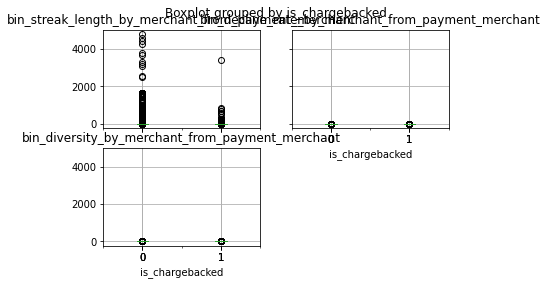

In [62]:
#sns.boxplot(x="is_chargebacked" 
#           , 
#            , data=df_features_subset,
#             palette="vlag")

df_features_subset.boxplot(column =["bin_streak_length_by_merchant_from_payment_merchant", 
                       "bin_decline_rate_by_merchant_from_payment_merchant",
                       "bin_diversity_by_merchant_from_payment_merchant"], by='is_chargebacked')

In [61]:
#x1 = df_features_subset.loc[df_features_subset.is_chargebacked==1, ['bin_streak_length_by_merchant_from_payment_merchant']]
#x2 = df_features_subset.loc[df_features_subset.is_chargebacked==0, ['bin_streak_length_by_merchant_from_payment_merchant']]


# plot
#kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

#plt.figure(figsize=(10,7), dpi= 80)
#sns.distplot(x1, color="dodgerblue", label="Compact", **kwargs)
#sns.distplot(x2, color="orange", label="SUV", **kwargs)
#plt.xlim(0,75)
#plt.legend();

In [ ]:
#cols = df_features_new.columns.tolist()
#to_remove = cols[0:3] + [cols[6]] + cols[9:32]
#to_remove
#df_features_new.iloc[:,  ~df_features_new.columns.isin(to_remove)]
#df_group = df_features_new.drop(df_features_new.iloc[:,  ~df_features_new.columns.isin(to_remove)], axis=1).groupby(['is_chargebacked']).sum().T